**Traffic-sign recognition system**

**Import necessary libraries**

In [147]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


**Fetch the path for the images**

In [148]:
data = []
labels = []
classes = 43
dataset_dir = 'C:/Users/ROUCHI/Desktop/Datasets/archive'
#Retrieving the images and their labels 
metaDf = pd.read_csv('C:/Users/ROUCHI/Desktop/Datasets/archive/Meta.csv') 
trainDf = pd.read_csv('C:/Users/ROUCHI/Desktop/Datasets/archive/Train.csv') 
testDf= pd.read_csv('C:/Users/ROUCHI/Desktop/Datasets/archive/Test.csv') 
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']
print('SHAPE of training set:',trainDf.shape)
print('SHAPE of test set:',trainDf.shape)
print('SHAPE of MetaInfo:',trainDf.shape)


SHAPE of training set: (39209, 8)
SHAPE of test set: (39209, 8)
SHAPE of MetaInfo: (39209, 8)


**Load the path**

In [149]:
trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))


In [150]:
trainDf.sample(10)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
3773,52,49,6,6,47,44,2,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
10031,35,31,6,5,30,26,5,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
3754,30,29,6,6,25,24,2,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
32133,36,35,5,5,31,30,31,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
11114,40,39,5,6,35,34,7,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
18326,106,104,9,10,97,95,11,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
11975,32,32,5,5,27,27,7,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
11004,41,43,5,6,36,38,7,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
6615,62,61,6,6,57,56,4,C:/Users/ROUCHI/Desktop/Datasets/archive\train...
12566,94,94,9,8,86,86,8,C:/Users/ROUCHI/Desktop/Datasets/archive\train...


In [151]:
metaDf.sample(10)

,Path,ClassId,ShapeId,ColorId,SignId
20,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,26,0,0,1.24
37,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,42,1,3,3.28
38,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,5,1,0,3.29
23,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,3,1,0,3.29
8,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,15,1,0,3.1
7,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,14,3,0,2.2
29,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,35,1,1,4.1
39,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,6,1,3,3.3
41,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,8,1,0,3.29
14,C:/Users/ROUCHI/Desktop/Datasets/archive\meta/...,20,0,0,1.1


**Analyze the class distribution using Histogram**

<Axes: title={'center': 'Test classes distribution'}, xlabel='Class ID', ylabel='Count'>

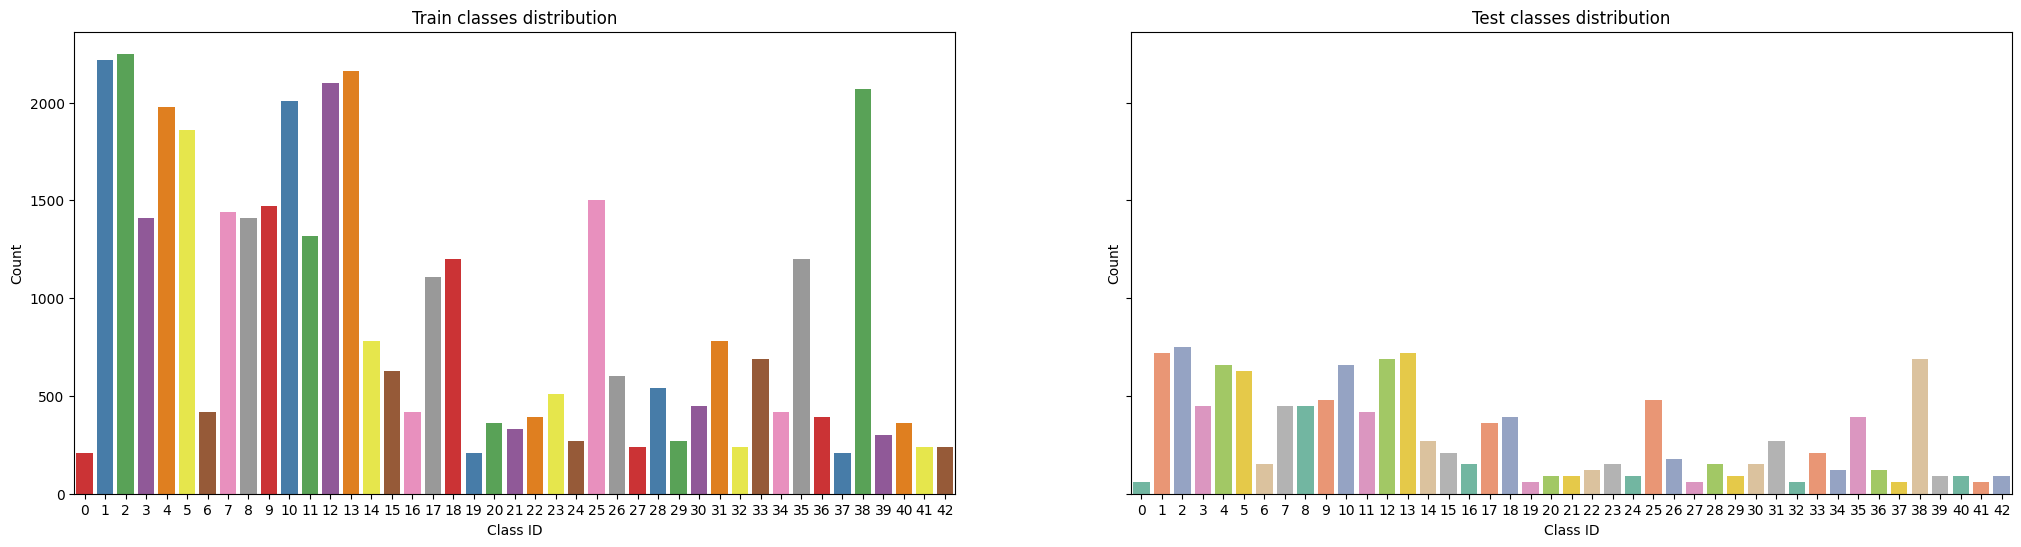

In [152]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))

axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class ID')
axs[0].set_ylabel('Count')

axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class ID')
axs[1].set_ylabel('Count')

# Use hue='ClassId' and legend=False to remove FutureWarning
sns.countplot(x="ClassId", hue="ClassId", data=trainDf, ax=axs[0], palette="Set1", legend=False)
sns.countplot(x="ClassId", hue="ClassId", data=testDf, ax=axs[1], palette="Set2", legend=False)



**Analyze the size distribution of images**

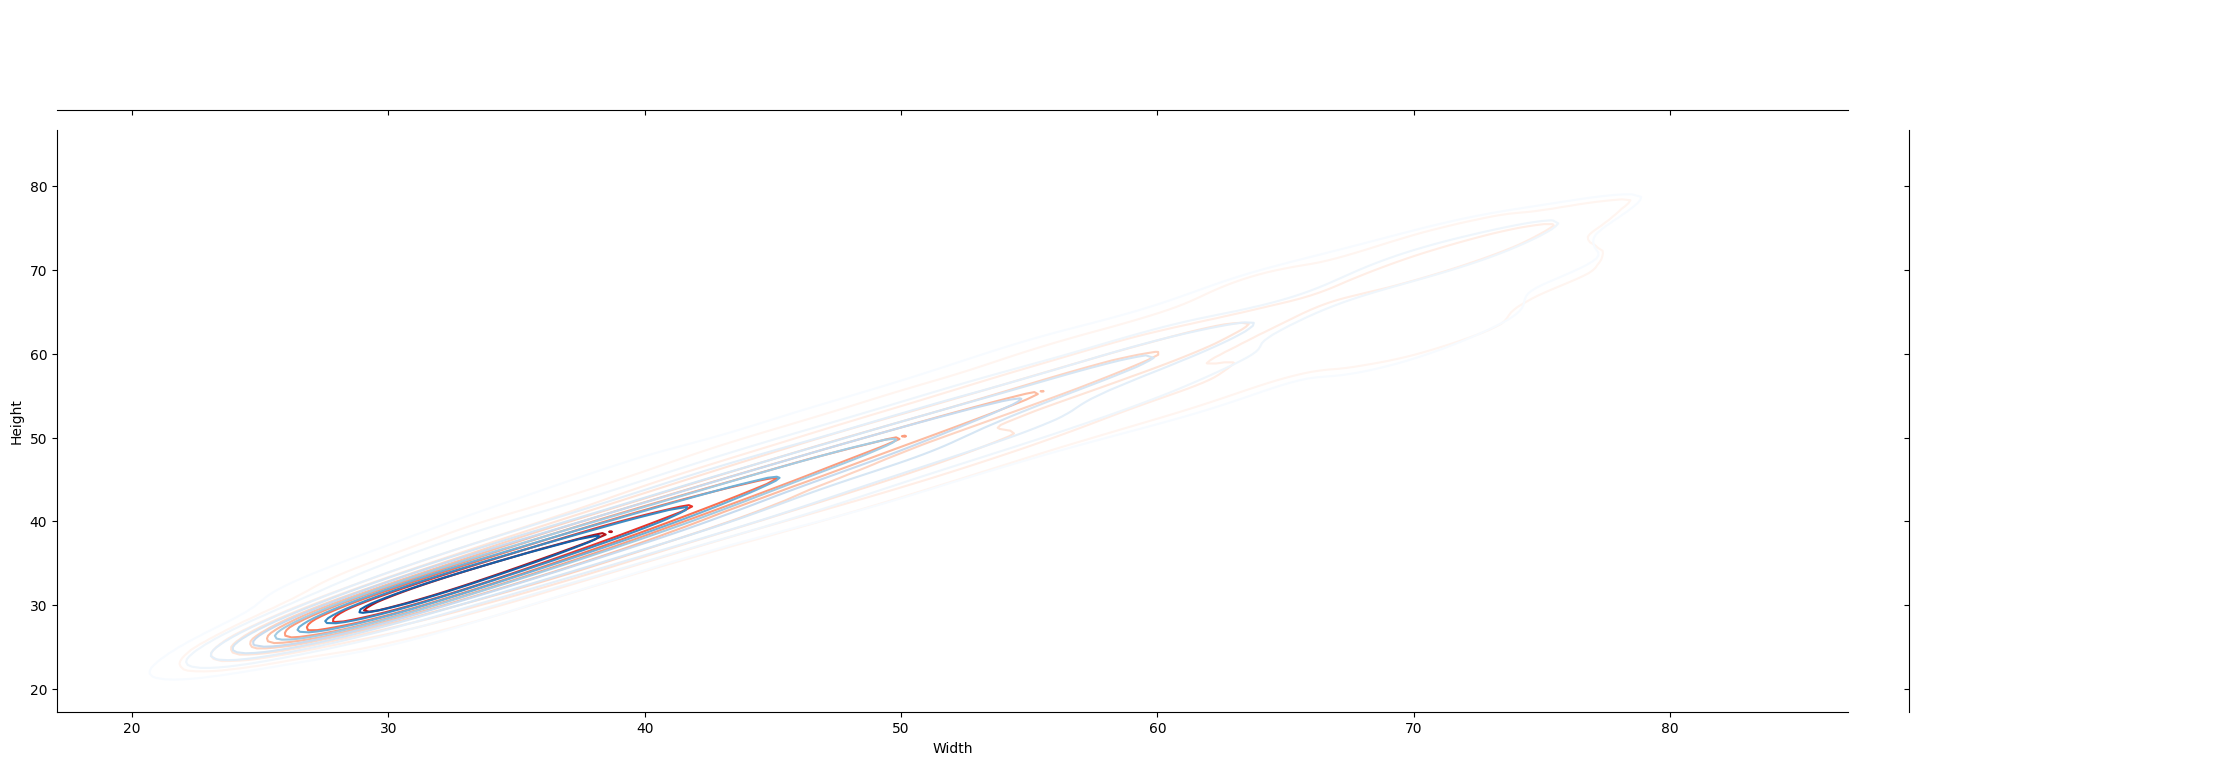

In [153]:
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)]
testDfDpiSubset = testDf[(testDf.Width < 80) & (testDf.Height < 80)]

g = sns.JointGrid(x="Width", y="Height", data=trainDfDpiSubset)

sns.kdeplot(x=trainDfDpiSubset.Width, y=trainDfDpiSubset.Height, cmap="Reds", fill=False, ax=g.ax_joint)
sns.kdeplot(x=testDfDpiSubset.Width, y=testDfDpiSubset.Height, cmap="Blues", fill=False, ax=g.ax_joint)

g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show()



**Visualize the target class**

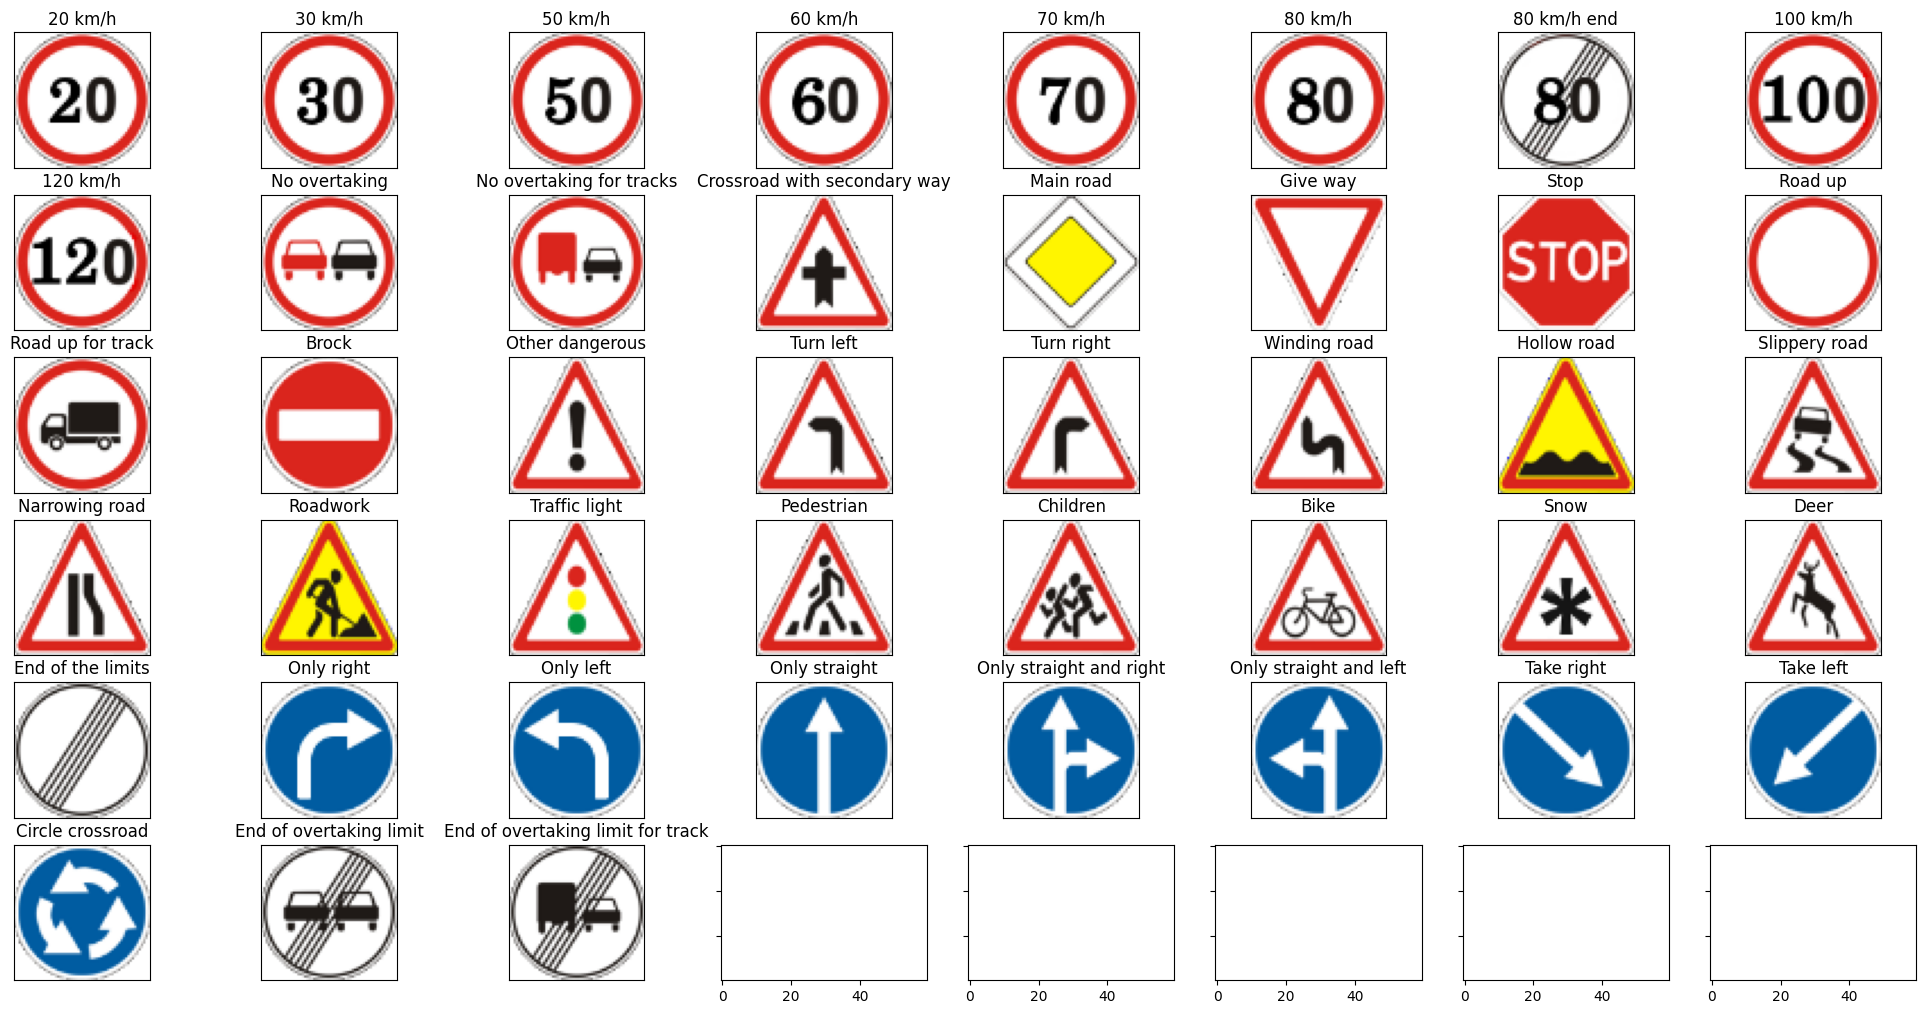

In [154]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])
idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1


**Visualize the training dataset**

C:/Users/ROUCHI/Desktop/Datasets/archive


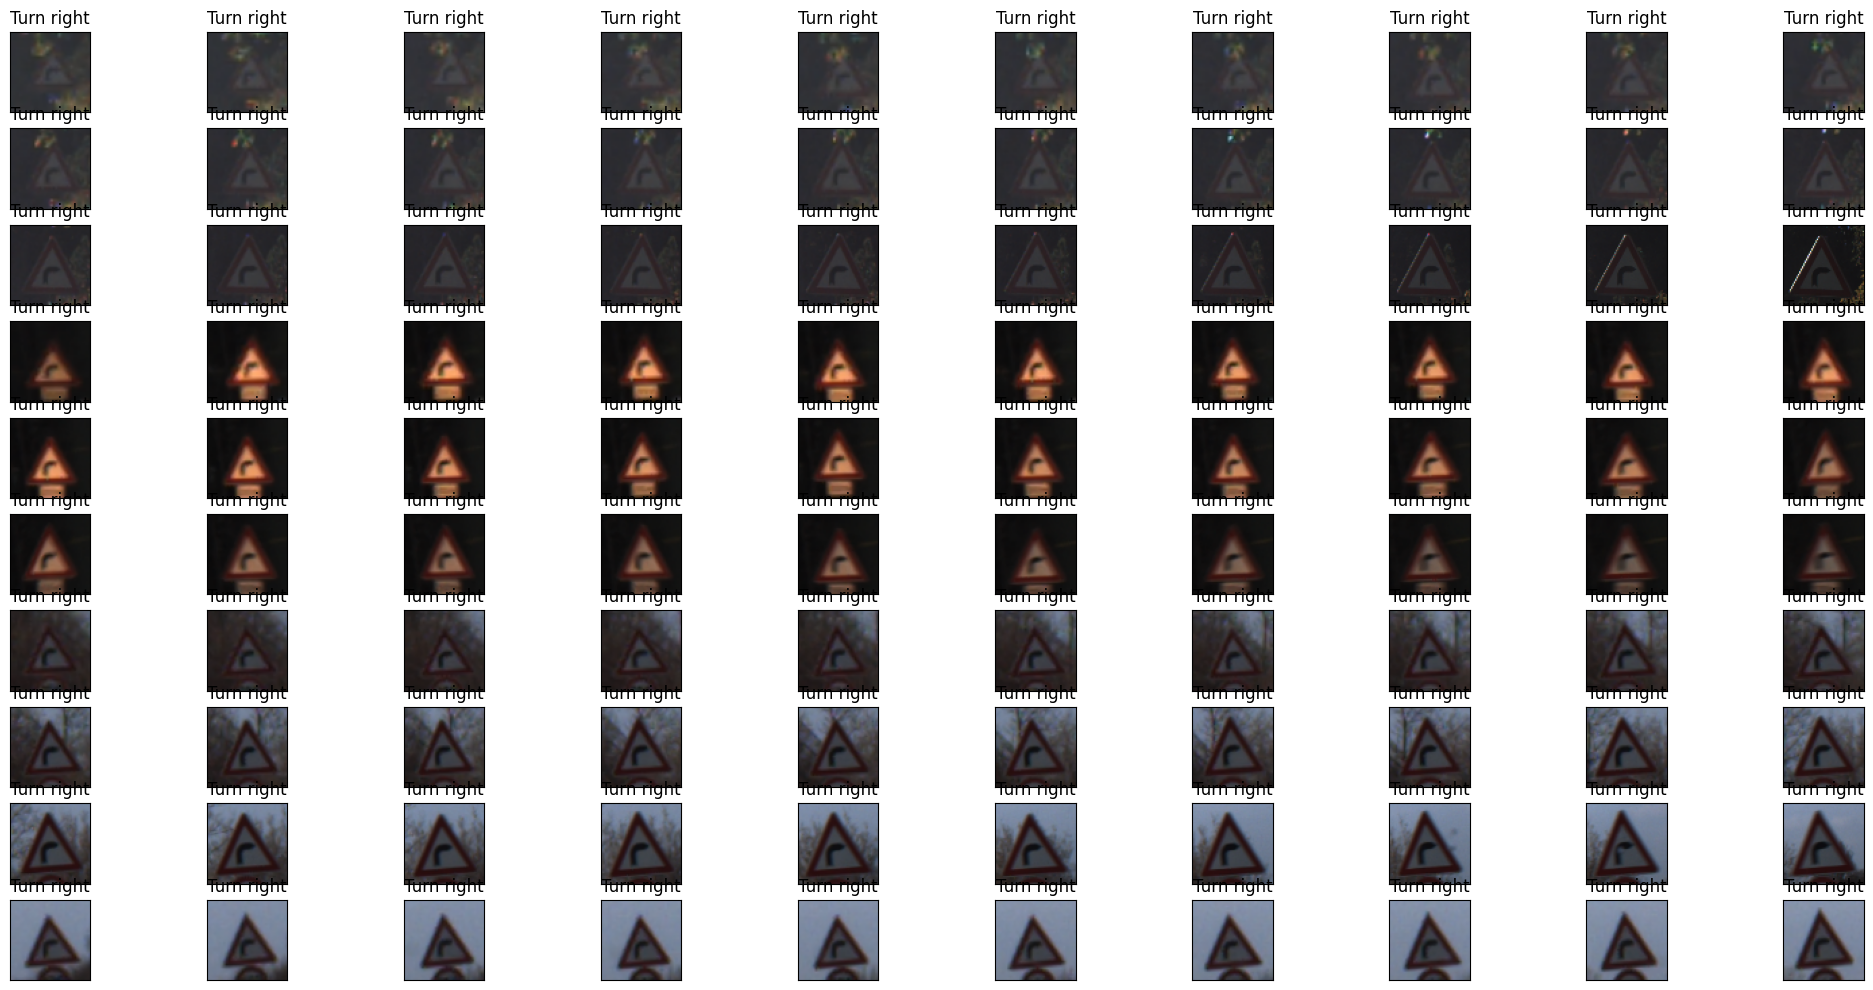

In [155]:
rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
cur_path = 'C:/Users/ROUCHI/Desktop/Datasets/archive'
print(cur_path)
idx = 0
for i in range(rows):
    for j in range(cols):
        path = os.path.join(cur_path,trainDf["Path"].tolist()[idx]) 
        img = cv2.imread(path,cv2.IMREAD_UNCHANGED)
        #print(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(trainDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1


**Model building using**

In [156]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


**Extract the path for training, testing and label images**

In [157]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()
print(cur_path)
#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'C:/Users/ROUCHI/Desktop/Datasets/archive/Train',str(i))
    images = os.listdir(path)
    print(path)
    print(images)
    #Converting lists into numpy arrays
    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")



c:\Users\ROUCHI\.vscode\Traffic-sign recognition system
C:/Users/ROUCHI/Desktop/Datasets/archive/Train\0
['00000_00000_00000.png', '00000_00000_00001.png', '00000_00000_00002.png', '00000_00000_00003.png', '00000_00000_00004.png', '00000_00000_00005.png', '00000_00000_00006.png', '00000_00000_00007.png', '00000_00000_00008.png', '00000_00000_00009.png', '00000_00000_00010.png', '00000_00000_00011.png', '00000_00000_00012.png', '00000_00000_00013.png', '00000_00000_00014.png', '00000_00000_00015.png', '00000_00000_00016.png', '00000_00000_00017.png', '00000_00000_00018.png', '00000_00000_00019.png', '00000_00000_00020.png', '00000_00000_00021.png', '00000_00000_00022.png', '00000_00000_00023.png', '00000_00000_00024.png', '00000_00000_00025.png', '00000_00000_00026.png', '00000_00000_00027.png', '00000_00000_00028.png', '00000_00000_00029.png', '00000_00001_00000.png', '00000_00001_00001.png', '00000_00001_00002.png', '00000_00001_00003.png', '00000_00001_00004.png', '00000_00001_00005.

**Read the images and convert to numpy arrays**

In [158]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)


(39209, 30, 30, 3) (39209,)


**Split the training set**

In [159]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


**Convert the label using one hot encoding **

In [160]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)



**CNN model**

In [161]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


C:\Users\ROUCHI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Model compilation**

In [162]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 76s 73ms/step - accuracy: 0.2697 - loss: 3.5215 - val_accuracy: 0.8146 - val_loss: 0.6517
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.6875 - loss: 1.0355 - val_accuracy: 0.8813 - val_loss: 0.3964
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 75s 67ms/step - accuracy: 0.7605 - loss: 0.7754 - val_accuracy: 0.9102 - val_loss: 0.3041
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 69ms/step - accuracy: 0.7994 - loss: 0.6520 - val_accuracy: 0.9255 - val_loss: 0.2621
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - accuracy: 0.8234 - loss: 0.5738 - val_accuracy: 0.9288 - val_loss: 0.2517
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - accuracy: 0.8318 - loss: 0.5404 - val_accuracy: 0.9297 - val_loss: 0.2227
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.8471 - loss: 0.5049 - val_accuracy: 0.9314 - val_loss: 0.2081
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.8584 - loss: 0.4618 - 

**Plot the accuracy and loss**

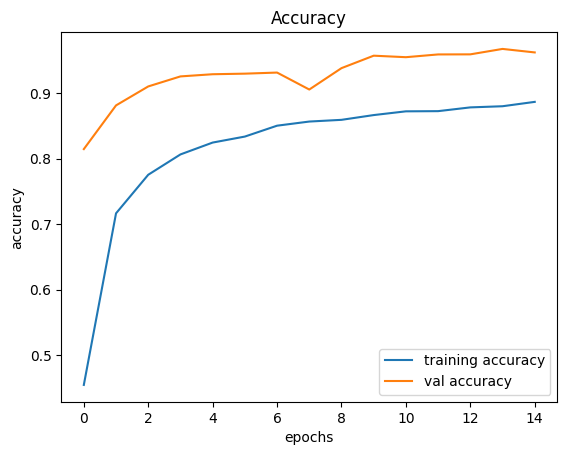

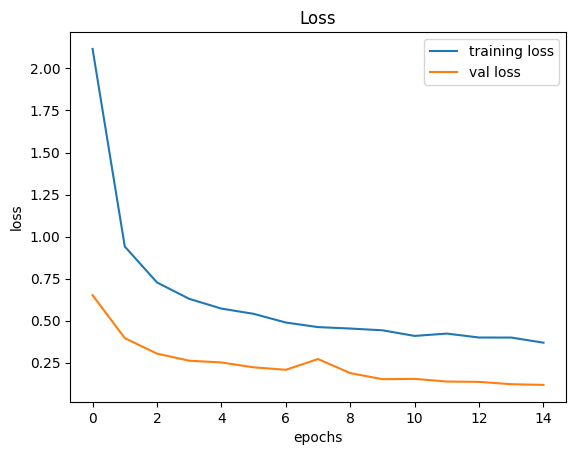

In [163]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


** Load the test data along with labels**

In [164]:
import os


path = r"C:\Users\ROUCHI\Desktop\Datasets\archive\Test"


if os.path.exists(path):
    images = os.listdir(path)
    print("Test image path:", path)
    print("Found", len(images), "images")
else:
    print("Path does not exist:", path)



Test image path: C:\Users\ROUCHI\Desktop\Datasets\archive\Test
Found 12631 images


**Predict the class**

In [165]:
# Predict
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob, axis=1)


from sklearn.metrics import accuracy_score
# Decode one-hot back to labels 
y_test_labels = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_test_labels, pred))


246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Accuracy: 0.9621270084162203
